# Load dependencies

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pickle
from pathlib import Path

# Define useful variables

In [22]:
MODELS_DIR = Path("iris-model")
SKLEARN_MODEL_PATH = MODELS_DIR.joinpath("sklearn/model.pk")
TF_MODEL_PATH = MODELS_DIR.joinpath("keras/model.keras")

SKLEARN_MODEL_PATH.parent.mkdir(exist_ok=True, parents=True)
TF_MODEL_PATH.parent.mkdir(exist_ok=True, parents=True)

# Load Data

In [7]:
iris_dataset = load_iris()
df = pd.DataFrame(iris_dataset.data, columns=iris_dataset.feature_names)
df["target"] = iris_dataset.target
X, y = df.drop("target", axis=1), df["target"]

In [8]:
X.shape

(150, 4)

In [9]:
y.shape

(150,)

# Model train

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120,) (30,)


In [11]:
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=1),
    "Naive Bayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(kernel="linear"),
    "Logistic Regression": LogisticRegression(),
}

# Test harness
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    results[name] = round(acc, 2)
results


{'Decision Tree': 0.97,
 'Naive Bayes': 0.97,
 'LDA': 1.0,
 'QDA': 1.0,
 'KNN': 1.0,
 'SVM': 1.0,
 'Logistic Regression': 0.97}

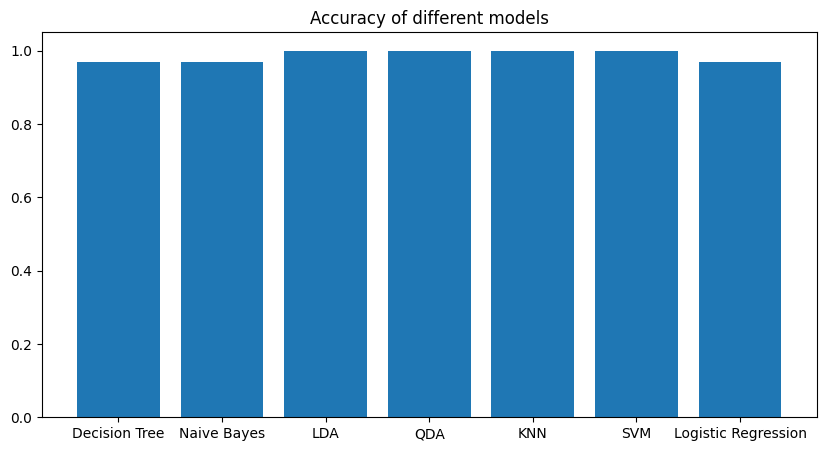

In [12]:
# Plot results
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values())
plt.title("Accuracy of different models")
plt.show()

In [13]:
# Print results
best_model = max(results, key=results.get)
print(f"The best model is {best_model} with an accuracy of {results[best_model]:.2f}")

The best model is LDA with an accuracy of 1.00


In [14]:
# save the model to disk
pickle.dump(
    models[best_model], open(SKLEARN_MODEL_PATH, "wb")
)  # export the model to a file so we can use it later


# Train model using Tensorflow

In [1]:
import tensorflow as tf
import keras 
from keras import Sequential
from keras import layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from pathlib import Path
import numpy as np

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
train_dataset, metadata = tfds.load("iris", with_info=True, as_supervised=True, split="train", batch_size=32)
num_examples = metadata.splits["train"].num_examples
num_classes = metadata.features["label"].num_classes
label_names = metadata.features["label"].names

In [19]:
label_names

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

(32, 4)


2025-03-01 11:39:15.673176: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


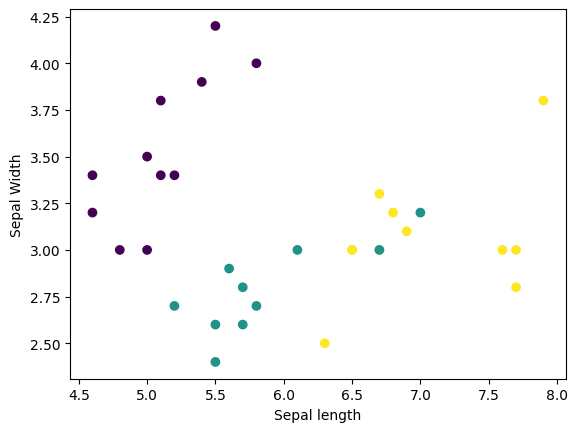

In [7]:
features, labels = next(iter(train_dataset))
sepal_length = features[:,0]
sepal_width = features[:,1]
print(features.shape)

plt.scatter(sepal_length,
            sepal_width,
            c=labels,
            cmap='viridis')
plt.xlabel("Sepal length")
plt.ylabel("Sepal Width")
plt.show()

In [8]:
net = Sequential([
  layers.Input(shape=(4,)),
  layers.Dense(10, activation="relu", name= "input"),
  layers.Dense(5, activation="relu", name= "hidden"),
  layers.BatchNormalization(),
  layers.Dense(3, activation="softmax", name="output")
])

In [9]:
net.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (Dense)                   │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143 (572.00 B)

 Trainable params: 133 (532.00 B)

 Non-trainable params: 10 (40.00 B)

In [11]:
loss_fun = tf.keras.losses.SparseCategoricalCrossentropy()
opt_fun = tf.keras.optimizers.Adam()
net.compile(optimizer=opt_fun, loss=loss_fun, metrics=['accuracy'] )
history = net.fit(train_dataset, batch_size=12, epochs=50)

Epoch 1/50


2025-03-01 11:44:05.147127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.5470 - loss: 0.8672
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5496 - loss: 0.8483
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5496 - loss: 0.8316
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5418 - loss: 0.8174
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5549 - loss: 0.8048
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5396 - loss: 0.7932 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5466 - loss: 0.7819 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5567 - loss: 0.7706
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5756 - loss: 0.7594
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5830 - loss: 0.7483
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5751 - loss: 0.7373
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5760 - loss: 0.7266
Epoch 13/50

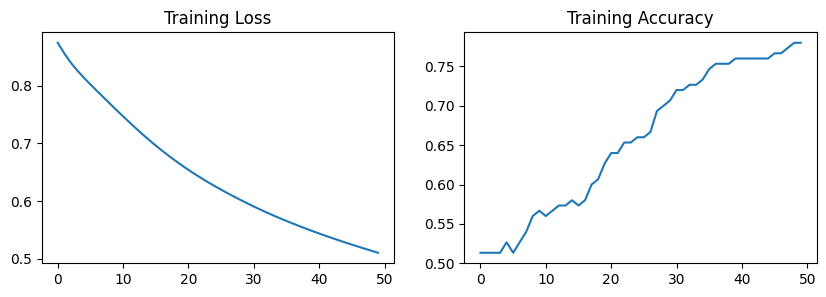

In [12]:
acc = history.history['accuracy']
loss = history.history['loss']
plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 2, 1)
ax.set_title("Training Loss")
ax.plot(loss)
ax = plt.subplot(1, 2, 2)
ax.set_title("Training Accuracy")
ax.plot(acc)
plt.show()

In [14]:
predictions = net.predict(np.array([[0.5, 0.4, 0.8, 0.4]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step


In [20]:
class_index = np.argmax(predictions)
class_name = label_names[class_index]
print(f"Predicted class is {class_name}")

Predicted class is Iris-setosa


In [23]:
net.save(TF_MODEL_PATH)